In [1]:
import sys

sys.path.append('bert/')

import codecs
import collections
import json
import re
import os
import pprint
import numpy as np
import modeling
import tokenization
import numpy as np
import pandas as pd
import re, string, unicodedata
import os
from os import path

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score, 
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout


In [2]:
import torch
import time
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

D:\software\anaconda3\Lib\site-packages\transformers\utils\generic.py:481: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
#df = pd.read_csv('fake_or_real_news.csv')
#df = df[['title','text','label']]
#LENGTH=2000
#true = df[df['label'] == 'REAL'][:LENGTH]
#fake = df[df['label'] == 'FAKE'][:LENGTH]
#df['text'] = df['title'] + "" + df['text']
#del df['title']

In [4]:
df = pd.read_csv('IMDB Dataset.csv')
#review sentiment
df = df[['review','sentiment']]
df = df.rename(columns={'review':'text', 'sentiment':'label'})
LENGTH=2000
true = df[df['label'] == 'positive'][:LENGTH]
fake = df[df['label'] == 'negative'][:LENGTH]

In [5]:
df.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
true.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [7]:
null_df = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False) * 100

null_df = pd.concat([null_df, percent], axis = 1, keys = ['Counts', '% Missing'])
null_df.head()

,Counts,% Missing
text,0,0.0
label,0,0.0


In [8]:
true.shape, fake.shape # relative same size good for training model

((2000, 2), (2000, 2))

In [9]:
true['label'] = 1
fake['label'] = 0

df = pd.concat([true, fake],ignore_index= True).drop_duplicates()
df.sample(10)

,text,label
2640,"The man who gave us Splash, Cocoon and Parenth...",0
1938,Unfortunately this original mix of action and ...,1
1915,A glacier slide inside a cavernous ice mountai...,1
1387,Watching Midnight Cowboy is like taking a mast...,1
2245,When Carol (Vanessa Hidalgo) starts looking in...,0
164,Man with the Screaming Brain certainly isn't a...,1
1775,I've been writing hardboiled crime fiction for...,1
3978,"Another chapter in the ongoing question, whate...",0
1840,"Wow, don't watch this thinking it's going to b...",1
2319,its awful i cant believe that one of the great...,0


In [10]:
#nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [11]:
def strip_html(text):
  # get a BeautifulSoup object that follows standard structure
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text() # extract all the text from a page

# removing the square brackets
def remove_between_square_brackets(text):
  # '' replace patterns occured in left of text like \[[^]*\]
  return re.sub(r'[[^]*\]', '', text)

# removing URL's
def remove_urls(text):
  return re.sub(r'http\S+', '', text)

# removing the stopwords from text
def remove_stopwords(text):
  final_text = []
  for i in text.split():
    if i.strip().lower() not in stop:
      final_text.append(i.strip()) # strip(None) remove blank char in default
  return " ".join(final_text)
  
# removing the noisy text
def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  text = remove_stopwords(text)
  return text

# Apply function on review column
df['text'] = df['text'].apply(denoise_text)

df.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22032\3730573762.py:9: FutureWarning: Possible nested set at position 1
  return re.sub(r'[[^]*\]', '', text)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22032\3730573762.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,text,label
0,One reviewers mentioned watching 1 Oz episode ...,1
1,wonderful little production. filming technique...,1
2,thought wonderful way spend time hot summer we...,1
3,"Petter Mattei's ""Love Time Money"" visually stu...",1
4,"Probably all-time favorite movie, story selfle...",1


Word Embedding using BERT

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(df['text'], df['label'], random_state=2018, test_size=0.5, stratify = df['label'])
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, random_state=2018, test_size=0.4, stratify = y_temp)

In [13]:
max_len =  128
train_batch_size = 16
valid_batch_size = 16
epochs = 4
learning_rate = 1e-5
filters = 50
filter_sizes = [3, 4, 5] #[2, 3, 4] #[2, 3, 4, 5]
hidden_size = 768
dropout = 0.1

In [14]:
from transformers import BertTokenizer, BertModel, BertConfig

%env HTTPS_PROXY=http://localhost:10809

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

D:\software\anaconda3\Lib\site-packages\transformers\utils\generic.py:338: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


env: HTTPS_PROXY=http://localhost:10809


In [15]:
x_train_tokens = tokenizer.batch_encode_plus(
    x_train.tolist(),
    add_special_tokens = True,
    max_length = max_len,
    padding = 'max_length',
    truncation = True,
    return_token_type_ids=False,
    return_attention_mask = True,
    return_tensors = 'pt'
)

x_valid_tokens = tokenizer.batch_encode_plus(
    x_valid.tolist(),
    add_special_tokens = True,
    max_length = max_len,
    padding = 'max_length',
    truncation = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

x_test_tokens = tokenizer.batch_encode_plus(
    x_test.tolist(),
    add_special_tokens = True,
    max_length = max_len,
    padding = 'max_length',
    truncation = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

y_train_tensor = torch.tensor(y_train.values)
y_valid_tensor = torch.tensor(y_valid.values)
y_test_tensor = torch.tensor(y_test.values)

#DataLoaders -> data become iteral
batch_size = 16

train_data = TensorDataset(x_train_tokens['input_ids'], x_train_tokens['attention_mask'], y_train_tensor)
train_data_sampler = RandomSampler(train_data)
train_data_loader = DataLoader(train_data, sampler = train_data_sampler, batch_size = batch_size)

valid_data = TensorDataset(x_valid_tokens['input_ids'], x_valid_tokens['attention_mask'], y_valid_tensor)
valid_data_sampler = RandomSampler(valid_data)
valid_data_loader = DataLoader(valid_data, sampler = valid_data_sampler, batch_size = batch_size)


In [16]:
x_train_tokens, y_train_tensor

({'input_ids': tensor([[  101, 17982,  1011,  ...,  4297, 25377,   102],
         [  101,  3984,  2052,  ...,  1012,  4895,   102],
         [  101, 23811,  5830,  ...,     0,     0,     0],
         ...,
         [  101, 21660,  2066,  ...,     0,     0,     0],
         [  101,  4854,  2417,  ..., 26136,  2100,   102],
         [  101,  8659,  5982,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]])},
 tensor([0, 0, 1,  ..., 0, 0, 1]))

In [17]:
class bert_cnn_model(nn.Module):
    def __init__(self, model):
        super(bert_cnn_model, self).__init__()

        # NEB
        model_config = BertConfig.from_pretrained('bert-base-uncased', return_dict = False)
        self.bert = BertModel.from_pretrained('bert-base-uncased', config = model_config)
        for param in self.bert.parameters():
          param.requires_grad = True # 启用Bert梯度

        # MSFB
        # 不同大小的卷积核
        self.convs = nn.ModuleList([nn.Conv2d(1, filters, (k, 768)) for k in filter_sizes])
        self.relus = nn.ModuleList([nn.ReLU() for k in filter_sizes])
        self.dropouts = nn.ModuleList([nn.Dropout() for k in filter_sizes])
        # 统一输出长度50的向量
        self.pools = nn.ModuleList([nn.MaxPool1d(128-k+1) for k in filter_sizes])

        self.fc = nn.Linear(filters * len(filter_sizes), 2)
        # 使用softmax而不是sigmoid
        self.softmax = nn.LogSoftmax()

    def conv_and_pool(self, x, conv, relu, dropout, pool):
        x = x.unsqueeze(1) #由于使用的是Conv2d来实现，需要多补一个维度
        x = conv(x)
        x = relu(x)
        x = dropout(x)
        x = x.squeeze(3)
        x = pool(x)
        x = x.squeeze(2)
        return x

    def forward(self, x):
        context = x[0]
        mask = x[1]
        encoder_out, pooled = self.bert(context, attention_mask = mask)
        ls = [
            self.conv_and_pool(encoder_out, conv, relu, dropout, pool)
            for conv, relu, dropout, pool in zip(self.convs, self.relus, self.dropouts, self.pools)
          ]
        out = torch.cat(ls, 1)
        out = self.fc(out)
        return self.softmax(out)
    

In [18]:
import torch
torch.cuda.empty_cache()
bc_model = bert_cnn_model(nn.Module)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bc_model.to(device)

D:\software\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


bert_cnn_model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)

cross_entropy = nn.CrossEntropyLoss(weight = weights)


In [20]:
class_weights

array([1.0005005, 0.9995   ])

In [21]:
optimizer = torch.optim.AdamW(params = bc_model.parameters(), lr = learning_rate)

In [22]:
def adjust_learning_rate(optimizer, epoch, start_lr):
    lr = start_lr * (0.1 ** (epoch // 3))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [23]:
#Train model

def train_model(
    n_epochs,
    training_loader,
    validation_loader,
    model, 
    optimizer
  ):

    valid_loss_min = np.Inf

    train_loss_summary = []
    valid_loss_summary = []

    for epoch in range(1, n_epochs + 1):
        print("Epoch {:} / {:}".format(epoch, epochs))
        train_loss, valid_loss = 0, 0
        avg_train_accuracy, avg_valid_accuracy = 0, 0
        accuracy = 0
        model.train()
        train_predictions = []
        valid_predictions = []
        lr = adjust_learning_rate(optimizer, epoch, learning_rate)
        #training loop
        for idx, batch in enumerate(training_loader):
            batch = [r.to(device) for r in batch]
            input_ids, attention_masks, labels = batch
            model.zero_grad()  #clear previously calculated gradients
            outputs = model([input_ids, attention_masks])
            loss = cross_entropy(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss = train_loss + (1/(idx + 1) * (loss.item() - train_loss))
            predictions = torch.argmax(outputs, dim = 1)
            train_predictions.append(predictions.detach().cpu().numpy())
            accuracy += sum([1 if predictions[i] == labels[i] else 0 for i in range(len(labels))])
        
            
        avg_train_accuracy = accuracy / len(training_loader.dataset)
        print(f'\Training Accuracy: {avg_train_accuracy}')
        print(f'\Training Loss: {train_loss}')
        train_loss_summary.append(train_loss)
        
        #validation loop
        accuracy = 0
        model.eval()
        with torch.no_grad():
          for idx, bacth in enumerate(validation_loader):
              batch = [r.to(device) for r in batch]
              input_ids, attention_masks, labels = batch
              outputs = model(batch)
              loss = cross_entropy(outputs, labels)
              valid_loss = valid_loss + (1/(idx + 1) * (loss.item() - valid_loss))
              predictions = torch.argmax(outputs, dim = 1)
              valid_predictions.append(predictions.detach().cpu().numpy())
              accuracy += sum([1 if predictions[i] == labels[i] else 0 for i in range(len(labels))])
              
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'saved_wrights.pt')
        avg_valid_accuracy = accuracy / len(validation_loader.dataset)
        print(f'\Validation Accuracy: {avg_valid_accuracy}')
        print(f'\Validation Loss: {valid_loss}')
        print(f'\Learning Rate: {lr}')
        valid_loss_summary.append(valid_loss)
    
    return train_loss_summary, valid_loss_summary


In [24]:
train_losses, valid_losses = train_model(epochs, train_data_loader, valid_data_loader, bc_model, optimizer)

Epoch 1 / 4


D:\software\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


\Training Accuracy: 0.6728364182091046
\Training Loss: 0.6009995965957645
\Validation Accuracy: 0.6880733944954128
\Validation Loss: 0.500542402267456
\Learning Rate: 1e-05
Epoch 2 / 4
\Training Accuracy: 0.8534267133566783
\Training Loss: 0.34619738435745245
\Validation Accuracy: 0.8131776480400333
\Validation Loss: 0.33169618248939514
\Learning Rate: 1e-05
Epoch 3 / 4
\Training Accuracy: 0.9229614807403702
\Training Loss: 0.21107128921151164
\Validation Accuracy: 0.9382819015846539
\Validation Loss: 0.13778221607208252
\Learning Rate: 1.0000000000000002e-06
Epoch 4 / 4
\Training Accuracy: 0.9264632316158079
\Training Loss: 0.1909227418154479
\Validation Accuracy: 0.9382819015846539
\Validation Loss: 0.19518204033374786
\Learning Rate: 1.0000000000000002e-06


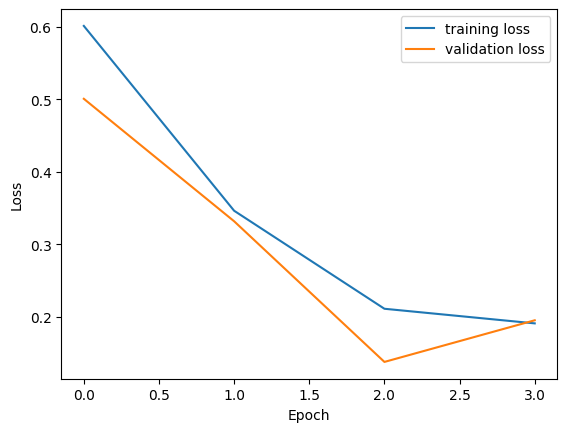

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label='training loss')
plt.plot(range(len(valid_losses)), valid_losses, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('losses.png')
plt.show()

In [26]:
bc_model.load_state_dict(torch.load('saved_wrights.pt'))

test_outputs = None
test_labels = None

with torch.no_grad():
    input_ids, attention_masks, labels = x_test_tokens['input_ids'], x_test_tokens['attention_mask'], y_test_tensor
    outputs = bc_model([input_ids.to(device), attention_masks.to(device)])
    test_outputs = outputs.detach().cpu().numpy()
    test_labels = labels

D:\software\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)



Matthews Corr Coef: 0.6800340025502125
Precision: 0.8366336633663366
Recall: 0.845
f-1 score: 0.8399959998999975
confusion Matrix:
 [[334  66]
 [ 62 338]]

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       400
           1       0.84      0.84      0.84       400

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.84      0.84      0.84       800



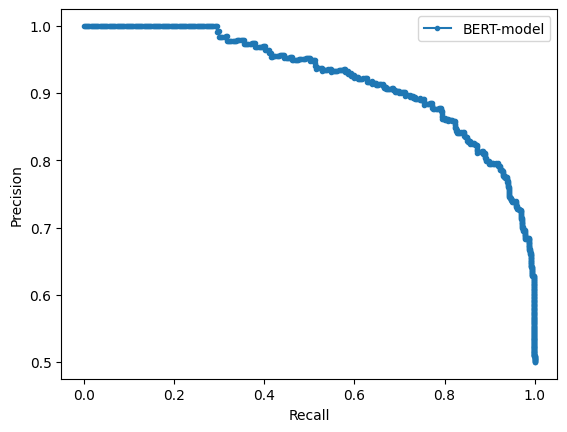

In [27]:
precision_, recall_, proba = precision_recall_curve(test_labels, test_outputs[:, -1])

preds = np.argmax(test_outputs, axis = 1)
mcc = matthews_corrcoef(test_labels, preds)
tn, fp, fn, tp = confusion_matrix(test_labels, preds).ravel()
precision = precision_score(test_labels, preds)
recall = recall_score(test_labels, preds)
f1 = f1_score(test_labels, preds, average='weighted')
cm = confusion_matrix(test_labels, preds)

print("")
print("Matthews Corr Coef:", mcc)
print("Precision:", precision)
print("Recall:", recall)
print("f-1 score:", f1)
print("confusion Matrix:\n", cm)
print("")
print(classification_report(test_labels, preds))

plt.plot(recall_, precision_, marker='.', label='BERT-model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('precision-reall-curve.png')

In [28]:
torch.cuda.empty_cache()

In [29]:
#84% [2, 3, 4, 5]
#83% [2, 3, 4]
#85% [2, 4, 5]
#84% [3, 4, 5]

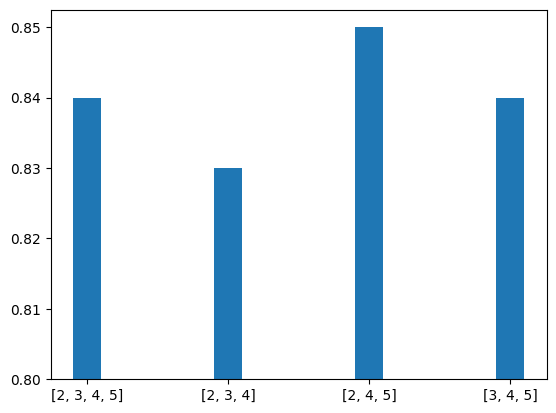

In [8]:
import matplotlib.pyplot as plt
plt.bar(["[2, 3, 4, 5]", "[2, 3, 4]", "[2, 4, 5]", "[3, 4, 5]"], [0.04, 0.03, 0.05, 0.04], width=0.2, bottom=0.8)
plt.show()